# RDS Homework 3 Template, Spring 2022


# Setup

In [130]:
!pip install shap

In [131]:
from __future__ import print_function

import shap
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [132]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism','christian']

In [133]:
# Initialize & fit tf-idf vectorizer (see notebook for lab 10)
vectorizer = TfidfVectorizer(min_df=1)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
Y_train = newsgroups_train.target
Y_test = newsgroups_test.target

In [134]:
# Train & fit the classifier 
model = SGDClassifier(loss="log")
model.fit(X_train,Y_train)

SGDClassifier(loss='log')

### Part (B)

Generate a confusion matrix (hint: use [sklearn.metrics.confusion_matrix](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))
to evaluate the accuracy of the classifier. The confusion matrix should contain a count of correct Christian, correct Atheist, incorrect Christian, and incorrect Atheist predictions.

In [135]:
# Generate predictions from your SGDClassifier
Y_pred = model.predict(X_test)

In [148]:
# Confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)
print("Correct Atheist (TN): " + str(confusion_matrix[0][0]))
print("Correct Christian (TP): " + str(confusion_matrix[1][1]))
print("Incorrect Atheist (FN): " + str(confusion_matrix[1][0]))
print("Incorrect Christian (FP): " + str(confusion_matrix[0][1]))

[[276  43]
 [  4 394]]
Correct Atheist (TN): 276
Correct Christian (TP): 394
Incorrect Atheist (FN): 4
Incorrect Christian (FP): 43


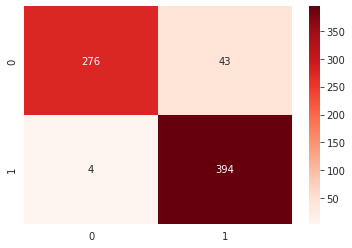

In [137]:
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', cmap='Reds')

#### Explainer

In [138]:
# Initialize the explainer and apply to test data
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [139]:
# Select 5 documents in the test set for explanation
X_test_array = X_test.toarray
docs = []
i = 0
while len(docs)<5:
  if len(docs)<3:
    if Y_test[i] == Y_pred[i]:
      docs.append(i)
  else:
    if Y_test[i] != Y_pred[i]:
      docs.append(i)
  i+=1

In [140]:
# Visually explain 5 documents selected from the test set
for i in docs:
  shap.initjs()
  classification = "correct"
  if Y_test[i] != Y_pred[i]:
    classification = "incorrect"
  print(f"Document {str(i)} is classified as {classification}")
  display(shap.force_plot(
      explainer.expected_value, 
      shap_values[i,:], X_test_array()[i,:],
      feature_names=vectorizer.get_feature_names_out()
  ))

Document 0 is classified as correct


Document 1 is classified as correct


Document 2 is classified as correct


Document 20 is classified as incorrect


Document 38 is classified as incorrect


### Part (C)


#### Part (i)

In [141]:
# Compute the accuracy of the classifier and the number of misclassified documents
print(f"Accuracy: {sklearn.metrics.accuracy_score(Y_pred, Y_test)}")
print(f"Misclassified Docs: {np.count_nonzero(Y_pred != Y_test)}")

Accuracy: 0.9344490934449093
Misclassified Docs: 47


#### Part (ii)

In [142]:
# function to calculate confidence
# (note: this function assumes your TF-IDF vectorized test data is called X_test)
def get_conf(doc_id):
  '''doc_id: the index of the misclassified documents'''
  conf = []
  for i in doc_id:
    prob = model.predict_proba(X_test[i])[0] 
    conf.append(abs(prob[0]-prob[1]))
  return conf

# Calculate conf_i for all misclassified documents 
misclassified_idx = []
for i in range(len(Y_pred)):
  if Y_pred[i] != Y_test[i]:
    misclassified_idx.append(i)
arr = get_conf(misclassified_idx)

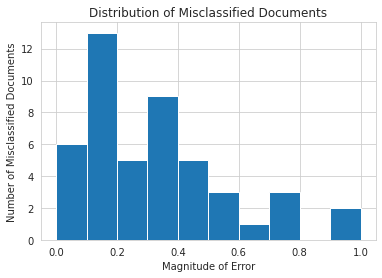

In [150]:
# Plot conf_i
plt.title("Distribution of Misclassified Documents")
plt.xlabel("Magnitude of Error")
plt.ylabel("Number of Misclassified Documents")
plt.hist(arr, bins=np.arange(0, max(arr) + 0.1,  0.1))
plt.show()

#### Part (iii)

Identify all words that contributed to the misclassification of documents. Hint: See the "Prediction decomposition" section of lab 10 notebook.

In [144]:
# Identify words (word_j) that contributed to the misclassification of documents
word_j = []
count_j = {}
weight_j = {}

for i in misclassified_idx:
  vals = shap_values[i,:]
  feats = vectorizer.get_feature_names()

  for word, weight in zip(feats, vals):
    if word.isalpha() and ((Y_pred[i] == 0 and weight < 0) or (Y_pred[i] != 0 and weight > 0)):
      if word not in word_j:
        word_j.append(word)

      if word not in count_j:
        count_j[word]=1
      else:
        count_j[word]+=1

      if word not in weight_j:
        weight_j[word]=abs(weight)
      else:
        weight_j[word]+=abs(weight)

print(word_j)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


['aah', 'aap', 'ability', 'able', 'abo', 'aboard', 'abord', 'abortion', 'abortions', 'about', 'above', 'absence', 'absurd', 'absurdities', 'abundantly', 'abuses', 'accept', 'acceptance', 'accompanied', 'accomplished', 'accor', 'accusations', 'accuse', 'accusing', 'acooper', 'acquaintance', 'act', 'action', 'actions', 'activities', 'actually', 'adam', 'add', 'adda', 'addition', 'additions', 'addresses', 'adequately', 'adherence', 'administrators', 'admit', 'adulteries', 'adults', 'advocates', 'aesthetics', 'affect', 'affirmed', 'after', 'afterwards', 'ag', 'again', 'against', 'agency', 'ages', 'aggravated', 'agnostics', 'agree', 'agreed', 'agreement', 'agrees', 'agressive', 'ah', 'aimed', 'air', 'akin', 'al', 'ale', 'alexia', 'alien', 'alink', 'all', 'allah', 'allan', 'allegations', 'allen', 'allied', 'allow', 'allowed', 'allowing', 'almighty', 'almost', 'along', 'alot', 'alt', 'alternate', 'alternating', 'alternatives', 'always', 'america', 'american', 'americans', 'ames', 'amherst', '

In [145]:
# Compute the number of documents (count_j) these words helped to misclassify
print(count_j)

{'aah': 43, 'aap': 43, 'ability': 38, 'able': 37, 'abo': 43, 'aboard': 43, 'abord': 43, 'abortion': 42, 'abortions': 43, 'about': 18, 'above': 39, 'absence': 42, 'absurd': 43, 'absurdities': 43, 'abundantly': 43, 'abuses': 43, 'accept': 38, 'acceptance': 43, 'accompanied': 43, 'accomplished': 43, 'accor': 43, 'accusations': 42, 'accuse': 43, 'accusing': 43, 'acooper': 39, 'acquaintance': 43, 'act': 40, 'action': 43, 'actions': 43, 'activities': 40, 'actually': 39, 'adam': 39, 'add': 43, 'adda': 43, 'addition': 40, 'additions': 42, 'addresses': 41, 'adequately': 41, 'adherence': 43, 'administrators': 43, 'admit': 37, 'adulteries': 43, 'adults': 43, 'advocates': 43, 'aesthetics': 43, 'affect': 43, 'affirmed': 43, 'after': 34, 'afterwards': 43, 'ag': 43, 'again': 34, 'against': 34, 'agency': 43, 'ages': 41, 'aggravated': 43, 'agnostics': 43, 'agree': 37, 'agreed': 42, 'agreement': 43, 'agrees': 43, 'agressive': 43, 'ah': 43, 'aimed': 43, 'air': 40, 'akin': 43, 'al': 43, 'ale': 43, 'alexia

In [146]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j
print(weight_j)

{'aah': 0.0005589518416860104, 'aap': 0.0022358073667440416, 'ability': 0.03746877949783672, 'able': 0.017228041501438005, 'abo': 0.06743327302031998, 'aboard': 0.007306340350265016, 'abord': 0.001291701888406563, 'abortion': 0.031143886280753177, 'abortions': 0.0007024242412652263, 'about': 0.2269998610116798, 'above': 0.0849358755009227, 'absence': 0.007668937886212705, 'absurd': 0.013799265140200337, 'absurdities': 0.0034034397477471228, 'abundantly': 0.00021896861876802827, 'abuses': 0.0019813882256741328, 'accept': 0.0012244219258313125, 'acceptance': 0.000696697401102076, 'accompanied': 0.00031171339605549724, 'accomplished': 0.0026195916935012374, 'accor': 0.005293373932006336, 'accusations': 0.001491575276261591, 'accuse': 0.0003639380796000946, 'accusing': 0.0015318163586462775, 'acooper': 0.018283524941105904, 'acquaintance': 0.02931333150859943, 'act': 0.017329114145475468, 'action': 0.06251959614784718, 'actions': 0.012663323867055891, 'activities': 0.06771438766163079, 'ac

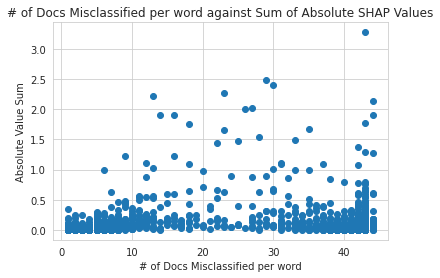

In [152]:
# Plot the distribution of count_j and weight_j
plt.title("# of Docs Misclassified per word against Sum of Absolute SHAP Values")
plt.xlabel("# of Docs Misclassified per word")
plt.ylabel("Absolute Value Sum")
plt.scatter(list(count_j.values()), list(weight_j.values()))
plt.show()